# Particle Swarm Demo 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output, display

In [3]:
def _display_progress(current_progress, progress):
        idx = np.where(progress - current_progress >= 0)[0][0] + 1
        perc = int(100. * idx / progress.shape[0])
        clear_output(wait = True)
        prg = "["
        prg += "".join(["=" for i in range(int(perc / 5))])
        prg += "".join(["." for i in range(20 - int(perc / 5))])
        prg += "".join("]")
        display(prg + "       " + 'Progress: ' + str(perc) + "%")

In [4]:
import sys

sys.path.insert(0, "../../src")

In [5]:
from env.light_grid import LightGrid
from env.metric import InnerProductL2
from walker.particle_swarm import ParticleSwarm, SwarmIntelligenceProcessor

In [6]:
x_l, x_r = -10, 10
y_l, y_r = -10, 10

In [7]:
def global_optimizer(x, y):
    return 1 / 1000 * (10 - x * np.sin(0.01 * x + y) + y ** 2 * np.cos(x) + x * y * np.sin(x + y) + \
            40 * x ** 2 * np.sin(y ** 4) - 34 * y ** 2 * np.sin(np.exp(-np.abs(x))))

In [8]:
xx = np.linspace(x_l, x_r, 100)
yy = np.linspace(y_l, y_r, 100)

X, Y = np.meshgrid(xx, yy)

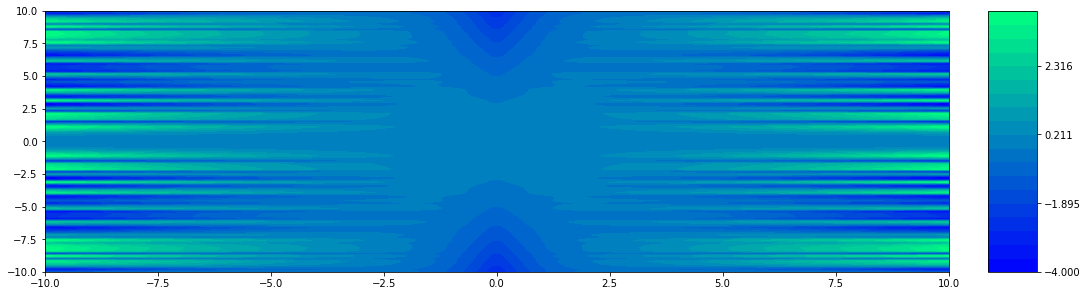

In [9]:
cmap = plt.get_cmap('winter')

levels = np.linspace(-4, 4, 20)

fig, ax = plt.subplots(constrained_layout = True)

fig.set_figwidth(15)

cs = ax.contourf(X, Y, global_optimizer(X, Y), levels, cmap = cmap)
c_bar = fig.colorbar(cs, ticks = levels[::5])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.show()

In [10]:
ip = InnerProductL2()

In [11]:
swarm_intelligence = SwarmIntelligenceProcessor(inner_product = ip)

In [12]:
grid = LightGrid(bounded = True, bounds = [(x_l, x_r), (y_l, y_r)], dr = np.ones(2) * 1e-2, dim = 2)
grid.add_processor(global_optimizer, name = "optimizer")

In [13]:
no_of_walkers = 200
no_of_steps = int(1e3)

def get_initial_coordinates(no, x_bounds, y_bounds):
    return np.random.uniform(low = x_bounds[0], high = x_bounds[1], size = no),\
            np.random.uniform(low = y_bounds[0], high = y_bounds[1], size = no)

In [14]:
coordinates = get_initial_coordinates(no_of_walkers, (-8, 8), (-10, 10))

In [15]:
coordinates = np.reshape(coordinates, (no_of_walkers, 2))

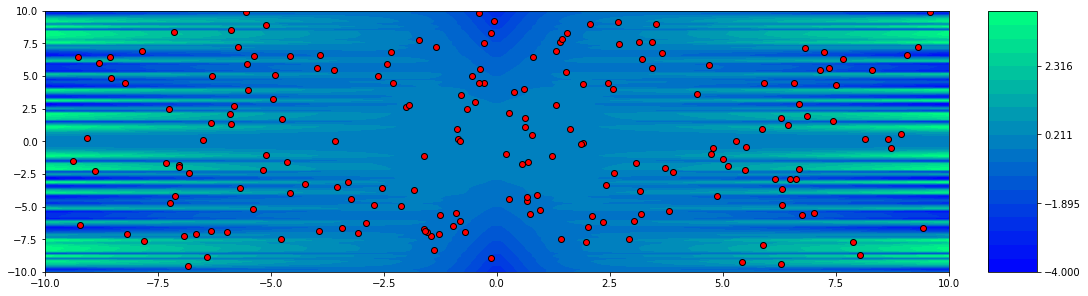

In [16]:
ax.scatter(coordinates[:,0], coordinates[:,1], c = 'r', edgecolor = 'k')
fig

In [17]:
swarm = ParticleSwarm(grid_dim = 2,\
                     no_of_walkers = no_of_walkers,\
                     inner_product = ip,\
                     initial_positions = coordinates,\
                     data_collection_keys = ["optimizer"],\
                     max_no_of_steps = no_of_steps,\
                     social_learning_coef = 15.0,\
                     cognitive_learning_coef = 8,)

In [18]:
prg = np.linspace(0, no_of_steps, no_of_steps)

for j in range(no_of_steps):
    next_positions = 0
    for i in range(no_of_walkers):
        curr, data = swarm._get_walker_info(i)
        data_collector = data[0]
        next_positions = grid._next(curr)
        eng_curr = grid.processors[data_collector](curr[0], curr[1])
        eng_next = np.array([grid.processors[data_collector](next_pos[0], next_pos[1]) for next_pos in next_positions])
        swarm.walk(i, next_positions, eng_next)
        curr, _ = swarm._get_walker_info(i)
        eng_ = grid.processors[data_collector](curr[0], curr[1])
        swarm.update_optimal_values(i, eng_)
    
    _display_progress(j, prg)

'[====================]       Progress: 100%'

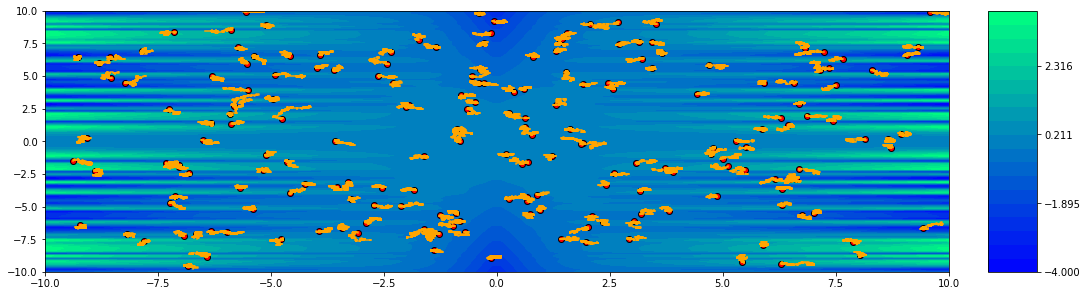

In [19]:
for wlk in swarm.walkers:
    ax.plot(wlk.visited[:, 0], wlk.visited[:, 1], c = 'orange')
fig

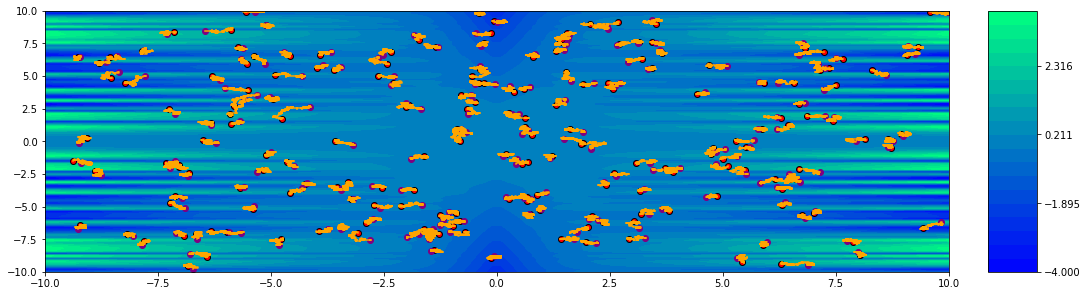

In [20]:
for wlk in swarm.walkers:
    ax.scatter(wlk.visited[-1, 0], wlk.visited[-1, 1], c = 'purple')
fig